# **Measure your PLR and PIPR with *PyPlr*!**
This notebook is a start-to-finish tutorial on how to use PyPlr to measure your PLR and PIPR. 
## **PLR - pupillary light reflex**
The constriction of the pupil following an increase in retinal illumination. When light strikes the retina, photons are absorbed by the photoreceptors and the sensory information travels along the afferent pathway, which consists of the photoreceptors, the bipolar cells, the ganglion cells, and terminates at the pretectal nucleus of the midbrain. The pretectal nucleus connects to the Edinger-Westphal nucleus, where the efferent pathway begins, and projects onwards to the iris sphincter muscle via the ciliary ganglion. Following the onset of a brief flash of light, a healthy pupil will begin to constrict after around 2-3 hundred ms. After reaching peak constriction, it will then enter a redilation phase and return to baseline. The function of the PLR may help to protect retinal photoreceptors from being exposed to dangerous levels of light, but its primary porpoise is to optimse visual acuity by regulating the ammount and trajectory of light that strikes the retina, like the aperture in a camera. 
## **PIPR - post-illumination pupil response**
The sustained constriction of the pupil following exposure to short wavelength blue light. In addition to the classical rod and cone photoreceptors, the retina also contains **intrinsically photosensetive retinal ganglion cells (ipRGCs)** which express the photopigment melanopsin, which is maximally sensetive to short wavelength (blue) light. The ipRGCs project to the suprachiasmatic neucleus and are involved in 'non-visual' functions, such as circadian photoentrainment and pupil control. The post illumination pupil response is usually characterised by comparing pupil responses to short- and long-wavelength lights. It is assumed to be a unique non-invasive signature of melanopsin processing in the human retina.
## ***PyPlr* - Python software for researching the pupillary light reflex**
PyPlr is a custom Python library supporting a broad range of research applications concerning pupillometry and the pupillary light reflex. It is developed against the [Pupil Core](https://pupil-labs.com/products/core/) (Pupil Labs, GmbH, Berlin) open-source eye tracking platform, which is relatively inexpensive, highly flexible, and provides accurate and precise measurement of pupil size. PyPlr contains tools to simplify working with a Pupil Core headset and for streamlining such processes as stimulus design, optimisation and delivery, communication with respect to timing, and extraction, cleaning, and analysis of the pupil data. When studting the pupillary light reflex, one must also use some sort of light source to illuminate the retina. Our solution is to use a custom built integrating sphere and a high-end 10-primary light engine for maximum control of the spectral and temporal properties of light stimuli. But one of the great things about PyPlr is that the time stamping of light stiuli is handled by leverging the innate capabilities of the eye tracker, so integration with a wide range of light sources and stimulus geometries is possible.


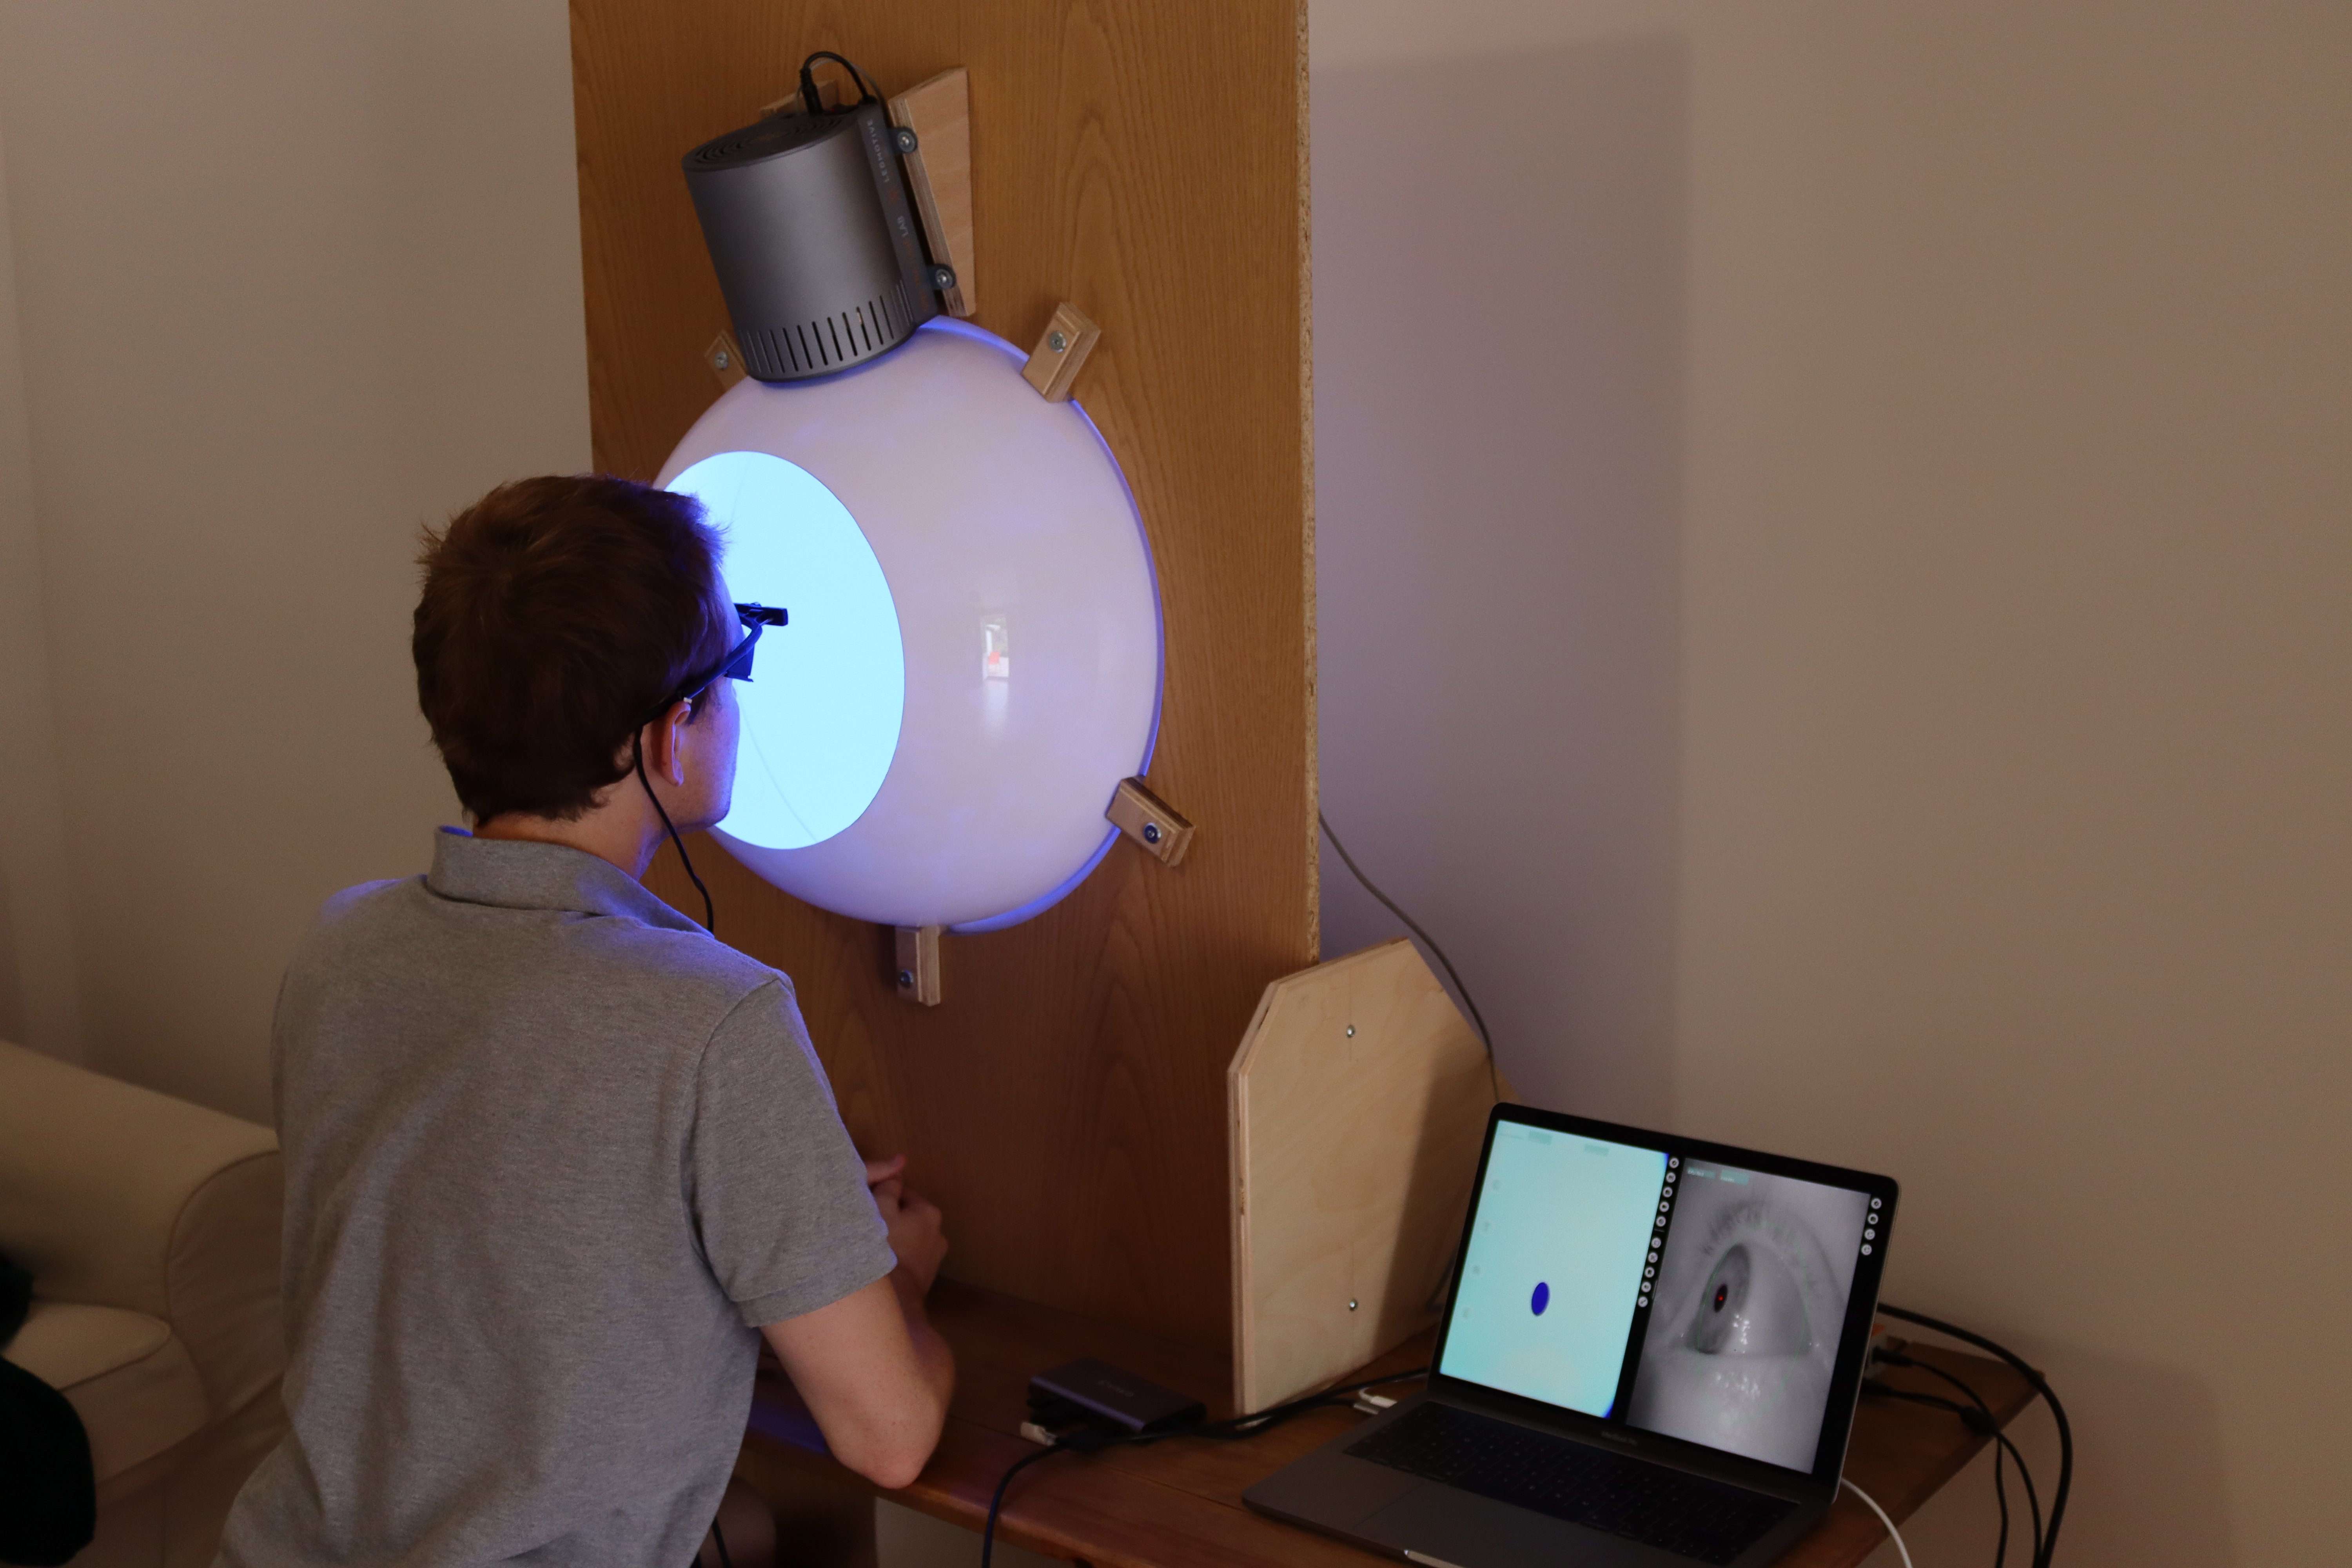

In [11]:
import sys
sys.path.insert(0, '../../')
from time import sleep

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pyplr import stlab

sns.set_context(context='notebook')
Image('../img/setup.JPG')


In [2]:
d = stlab.STLAB(username='admin', identity=1, password='83e47941d9e930f6')

STLAB device setup complete.


# Making PIPR stimuli
The goal is to create two light pulses that differentially excite melanopsin, but are matched for overall radiance. As an optimum protocol for exploring melanopsin function, Park et al. (2011) recommend comparing the pupil responses to high intensity (~400 lx) 1 s pulses of short and long wavelength light presented in the darkness. So we can start by creating a blue light with an intensity that is comfortable enough to endure for 1s. Then we load the lookup table created from the Ocean Optics spectrometer data which predicts the output of all leds at all intensity settings. Passing this to the `stlab.led_radiance_match(...)` function we get the required intensity that channel 9 (dark red) needs to be in order to match channel 4 (blue) at intensity=2000. Finally, we pass these values to `stlab.pulse_protocol(...)` to generate the video files.

In [17]:
blue = [0, 0, 0, 2500, 0, 0, 0, 0, 0, 0]
lkp_tbl = pd.read_csv('../data/corrected_oo_lookup_table.csv', 
                      index_col=['led','intensity'])
red_match = stlab.led_radiance_match(led=3, 
                                     intensity=2500, 
                                     match_led=9, 
                                     lkp_tbl=lkp_tbl)
red  = [0, 0, 0, 0, 0, 0, 0, 0, 0, red_match[1]]
stlab.pulse_protocol(pulse_spec=blue,
                     pulse_duration=1000, 
                     fname='1s_blue',
                     metadata={'color':'blue'})
stlab.pulse_protocol(pulse_spec=red, 
                     pulse_duration=1000, 
                     fname='1s_red',
                     metadata={'color':'red'})

"1s_blue.dsf" saved in the current working directory.
"1s_red.dsf" saved in the current working directory.


In [3]:
red_match

(0.00015233965594063648, 1979)

Let's visualise the stimuli with the melanopsin spectral sensitivity curve

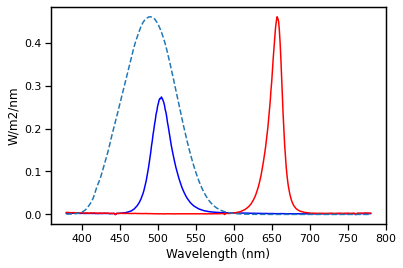

In [18]:
from pyplr.CIE import get_CIES026
_ , cies = get_CIES026(asdf=True)

fig, ax = plt.subplots()
wls = lkp_tbl.columns.to_numpy().astype('float')

ax.plot(wls, lkp_tbl.loc[(4,2000)], c='blue')
ax.plot(wls, lkp_tbl.loc[(9,red_match[1])], c='red')
    
ax2 = ax.twinx()
ax2.plot(wls, cies["Mel"], ls='dashed')
ax2.set_yticks([])

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('W/m2/nm')
f.savefig('mel.png', bbox_inches='tight')

# Setting up the experiment

In [31]:
import random
import os
recdir = os.getcwd()

# prepare stims
stims = ['blue.dsf', 'red.dsf'] * 3
random.shuffle(stims)
stims

['red.dsf', 'blue.dsf', 'blue.dsf', 'red.dsf', 'blue.dsf', 'red.dsf']

# Running the experiment

To see a maximal effect of melanopsin, dark adapt for 10 mins.

In [ ]:
# connect to Pupil Core
p = pupil.PupilCore()

# connect to stlab
d = stlab.SpectraTuneLab(username='admin', identity=1, password='83e47941d9e930f6')

# start recording
p.command('R {}'.format(os.getcwd()))

# wait a few seconds so you can get in place
sleep(5.)  

# loop over the list of stims
for stim in stims:
    
    # load video file and create trigger with metadata
    vf = d.load_video_file(stim)
    trigger = {**new_trigger('LIGHT_ON'), **vf['metadata']}
    
    # baseline
    sleep(10.)
    
    # set up and start the LightStamper thread 
    lst = pupil.LightStamper(p, threshold=15, trigger=trigger, wait_time=6)
    lst.start()
    
    # wait 200 ms
    sleep(.2)
    
    # play the video file
    d.play_video_file()
    sleep(60.)  

# finish recording
sleep(5.)   
p.command('r')

# Setting up the analysis

In [ ]:
# directories for analysis
expdir = os.getcwd()
subjdirs = [op.join(expdir, s) for s in os.listdir(expdir) if s.startswith('0')]

# columns to load and analyse
load_cols = ['pupil_timestamp', 
             'diameter', 
             'diameter_3d', 
             'method', 
             'confidence']
pupil_cols = ['diameter', 'diameter_3d']

# some constants
SAMPLE_RATE = 120
DURATION = 7800
ONSET_IDX = 600
STIM_DUR = 1 # second

# Data processing

In [15]:
# initialize subject analysis (get a handle on some helpful vars)
s = pupil.init_subject_analysis(subjdir, out_dir_nm='analysis')

# load data
samples = pupil.load_pupil(s['pl_data_dir'], cols=load_cols)
events  = pupil.load_annotations(s['pl_data_dir'])

# make figure for processing
f, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(14, 14))

# plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=False)

# mask pupil data which pass thresholds on the first derivative and the Pupil Labs confidence metric. 
# Handles most blinks and poor quality data.
samples = pupil.mask_pupil_first_derivative(samples, threshold=3.0, mask_cols=pupil_cols)
samples = pupil.mask_pupil_confidence(samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(title='Masked', ax=axs[1], legend=False)

# interpolate
samples = pupil.interpolate_pupil(samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(title='Interpolated', ax=axs[2], legend=False)

# smooth  
samples = pupil.butterworth_series(samples, 
                                   fields=pupil_cols, 
                                   filt_order=3, 
                                   cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(title='Butterworth filtered', ax=axs[3], legend=False)

for ax in axs:
    ax.set_ylabel('Pupil diameter')    
    ax.set_xlabel('Pupil timestamp')
axs[0].legend(loc='upper right', labels=['pixels','mm'])
f.suptitle('Data cleaning for subject: ' + s['id'])
#f.savefig(op.join(s['out_dir'], 'pupil_processing.png'))

# Trial extraction

In [ ]:
# extract the events and their baselines
ranges = pupil.extract(samples, 
                       events,
                       offset=-ONSET_IDX, 
                       duration=DURATION, 
                       borrow_attributes=['color'])
baselines = pupil.extract(samples, 
                          events, 
                          offset=-ONSET_IDX, 
                          duration=ONSET_IDX,
                          borrow_attributes=['color']).mean(level=0)
    
# new columns for baseline normalised data
ranges['diameter_pc'] = (ranges.diameter / baselines.diameter - 1).values * 100
ranges['diameter_3dpc'] = (ranges.diameter_3d / baselines.diameter_3d - 1).values * 100

# drop / markup bad trials
ranges = pupil.reject_bad_trials(ranges, interp_thresh=20, drop=True)

# calculate averages for conditions
averages = (ranges.reset_index()
                  .groupby(by=['color','onset'], as_index=True)
                  .mean())
    
# make figure for extraction, baseline-correction and averaging
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,5))
pal = {'blue': 'blue', 'red': 'red'}
# plot extracted trials
ranges.reset_index(inplace=True)
sns.lineplot(x='onset', y='diameter_3d', data=ranges, units='event', 
             hue='color', estimator=None, palette=pal,
             ax=axs[0], legend=False)
axs[0].set_ylabel('Pupil diameter (mm)')
axs[0].set_ylim((2,8))

axs[0].set_title('Extracted')

# plot baseline corrected trials
sns.lineplot(x='onset', y='diameter_3dpc', data=ranges, units='event', 
         hue='color', estimator=None,palette=pal,
         ax=axs[1], legend=False)
axs[1].set_title('Baseline-corrected')

# plot averages
axs[2].plot(averages.loc['red', 'diameter_3dpc'], color='red')
axs[2].plot(averages.loc['blue', 'diameter_3dpc'], color='blue')
axs[2].set_title('Averaged')

for ax in axs:
    ax.set_xlabel('Time (s)')
    ax.set_xticks(
        range(ONSET_IDX, DURATION + SAMPLE_RATE, SAMPLE_RATE * 10))
    ax.set_xticklabels([str(xtl) for xtl in range(0, 70, 10)])
    ax.axvspan(ONSET_IDX, ONSET_IDX + STIM_DUR, 0, 1, color='k', alpha=.2) 

for ax in axs[1:]:
    ax.set_ylabel('Pupil modulation (%)') 
    ax.hlines(0, 0, DURATION, color='k', ls=':', lw=1.5)
    ax.set_ylim((-60, 20))

f.suptitle('Subject: ' + s['id'])
f.tight_layout()
    #f.savefig(op.join(s['out_dir'], 'plr_extraction.png'))